# EVALUATION NOTEBOOK

#### Study on the effect of Prefilters
The dataset was transcribed with two different prefilters.
paired differences of the f-scores are shown as violinplot and boxplots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

def printRow(data,prefilter="RP",alphabet="majmin"):
    text = f"{prefilter} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)


print(f"----------Table of results------------")
rp_text = "RP &"
median_text = "Median &"
header = "prefilter & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    rp = utils.getFscoreResults("../results/prefilter_rp.hdf5",alphabet,True)
    median = utils.getFscoreResults("../results/prefilter_median.hdf5",alphabet, True)
    printRow(rp,"RP",alphabet)
    printRow(median,"Median",alphabet)
    print("\\midrule")

    # plot paired difference
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(rp[dset],median[dset])])
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    fig.savefig(f"../latex/figures/prefilter_delta_f_{alphabet}.png")
    ax.set_ylabel("delta F-score in %")
    # wilcoxon test
    print("-----Wilcoxon test for paired samples SEVENTHS-------")
    print("dataset & N & z & p & r \\\\")
    print("\\toprule")
    for i,dset in enumerate(["beatles","rwc\_pop","rw","queen","combined"]):
        N,p,z,r = utils.wilcoxonTest(deltas[i])
        if p < 0.001:
            print(f"{dset} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
        else:    
            print(f"{dset} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")


#### Study on Source Separation
Vocals, drums were removed seperately with a hybrid transformer source separation network (demucs) to enhance the chroma.</br>
After seperating the drums, the vocals were again removed from the remaining signal. F-scores for three source separation scenarios were computed (vocals removed, drums removed, vocals and drums removed)



----------Table of results------------
separation & scheme &beatles &rwc\_pop & rw &queen &combined \\


none & majmin &75.00$\pm$14.50 &76.00$\pm$16.00 &76.00$\pm$14.00 &70.50$\pm$17.00 &75.00$\pm$15.00 \\
vocals & majmin &76.00$\pm$13.00 &77.00$\pm$15.25 &78.00$\pm$14.00 &68.50$\pm$17.25 &77.00$\pm$13.00 \\
drums & majmin &75.00$\pm$13.00 &78.00$\pm$14.25 &79.00$\pm$15.00 &73.00$\pm$17.25 &76.00$\pm$14.00 \\
both & majmin &76.00$\pm$12.00 &77.00$\pm$13.00 &79.00$\pm$13.00 &75.50$\pm$19.50 &77.00$\pm$13.00 \\
--------comparison pairs for wilcoxon test----
beatles & none, vocals & 175 & -2.8 & 0.005 & 0.2\\
rwc_pop & none, vocals & 100 & -3.9 & $<$.001 & 0.4\\
rw & none, vocals & 61 & -4.5 & $<$.001 & 0.6\\
queen & none, vocals & 18 & -0.1 & 0.897 & 0.0\\
combined & none, vocals & 354 & -5.8 & $<$.001 & 0.3\\
beatles & none, drums & 175 & -0.0 & 0.969 & 0.0\\
rwc_pop & none, drums & 100 & -5.2 & $<$.001 & 0.5\\
rw & none, drums & 61 & -4.9 & $<$.001 & 0.6\\
queen & none, drums & 18 & -2.4 & 0.017 & 0.6\\
combined & none, drums & 354 & -5.1 & $<$.001 & 0.3\\
beatles & none, both & 175 & -2

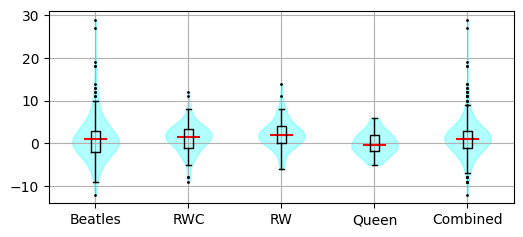

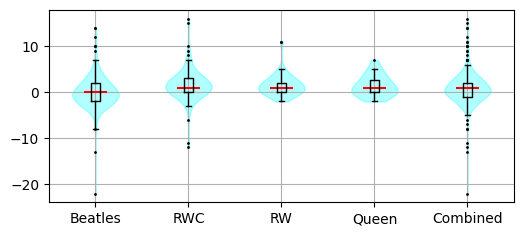

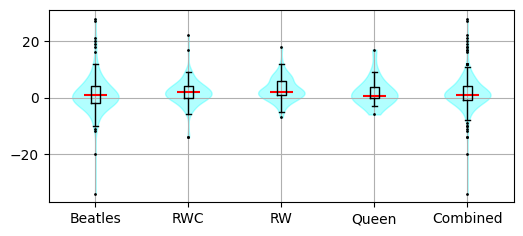

In [56]:
import h5py

def getFscoreResults(filepath,alphabet, printMetadata=True):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f = subgrp.attrs.get(f"{alphabet}_f")
                    f_scores.append(100 * f)
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

def printHeader():
    print(f"----------Table of results------------")
    header = "separation & scheme &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        if dset == "rwc_pop":
            header += "rwc\_pop & "
        else:
            header += dset +" &"
    header = header[:-1] + "\\\\"
    print(header)

def printRowFscore(data,method="none",alphabet="majmin"):
    text = f"{method} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def printRowTtest(data,pair="none"):
    res = scipy.stats.wilcoxon(data,method='approx')
    N = len(data)
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {pair} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {pair} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")

printHeader()
data = {}
for separation in ["none","vocals","drums","both"]:
    data[separation] = getFscoreResults(f"../results/source_separation_{separation}","majmin",False)
    printRowFscore(data[separation][0],method=separation,alphabet="majmin")

# check if the f-score results are in correct order for all files
for a,b,c,d in zip(data["none"][1],data["vocals"][1],data["drums"][1],data["both"][1]):
    if a != b or b != c or c != d or a != d:
        raise ValueError("filenames don't match!")

print("--------comparison pairs for wilcoxon test----")
# mix,vocals - mix,drums - mix, vocals/drums
row = "Comparison Pair"
for sep in ["vocals","drums","both"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[sep][0][dset],data["none"][0][dset])]
        printRowTtest(delta,f"none, {sep}")
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    fig.savefig(f"../latex/figures/separation_{sep}_delta_majmin.png")


#### Study on correlation vs inner product

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import utils

def printRow(data,mof="inner",alphabet="majmin"):
    text = f"{mof} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.1f}$\\pm${iqr:0.1f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def getResults(filepath,alphabet="majmin",printMetadata=False):
    results_corr = {"combined":[]}
    results_inner = {"combined":[]}
    results_deltas = {"combined":[]} # correlation - innerproduct
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores_corr = []
            f_scores_inner_product = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f_scores_corr.append(100 * subgrp.attrs.get(f"{alphabet}_f_correlation"))
                    f_scores_inner_product.append(100 * subgrp.attrs.get(f"{alphabet}_f_inner_product"))
            results_corr[dset] = f_scores_corr
            results_inner[dset] = f_scores_inner_product
            results_deltas[dset] = [x-y for x,y in zip(f_scores_corr,f_scores_inner_product)]
            results_corr["combined"] += f_scores_corr
            results_inner["combined"] += f_scores_inner_product
            results_deltas["combined"] += results_deltas[dset]
    return results_corr,results_inner,results_deltas,track_list

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
text = "Median &"
header = "distance & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    results_corr,results_inner,results_deltas,track_list = getResults("../results/distance_measure.hdf5",alphabet,False)
    printRow(results_corr,"correlation",alphabet)
    printRow(results_inner,"inner product",alphabet)
    print("\\midrule")

    # plot sorted results
    index = np.argsort(results_inner["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(np.array(results_inner["combined"])[index],'k')
    ax.plot(np.array(results_corr["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["inner","corr"])
    fig.savefig(f"../latex/figures/corr_sorted_{alphabet}.png")

    # plot deltas
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,[x for x in results_deltas.values()],xlabels)
    ax.set_ylabel("delta F-score in %")
    fig.savefig(f"../latex/figures/corr_delta_{alphabet}.png")

    print(f"Wilcoxon Test: combined dataset {alphabet}")
    (N,p,z,r) = utils.wilcoxonTest(results_deltas["combined"])
    if p < 0.001:
        print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
    else:    
        print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")

#### Comparison of Chord Recognition models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import utils

def getResults(filepath,printMetadata=True):
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]

getResults("../results/crp_nodrums_key.hdf5")


#### Deep Chroma experiments

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import utils

# est_cpss_majmin_f, stable_cpss_majmin_f
# est_templates_majmin_f, stable_templates_majmin_f

def getFscoreResults(filepath, model, alphabet, printMetadata=True):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f = subgrp.attrs.get(f"{model}_{alphabet}_f")
                    if f is None: # deep chroma estimation is stored in different format!
                        f = subgrp.attrs.get(f"{alphabet}_f")
                    f_scores.append(100 * f)
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

def printRow(data,model="inner",alphabet="majmin"):
    text = f"{model} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.1f}$\\pm${iqr:0.1f} &"
    text = text[:-1]+ "\\\\"
    print(text)

data = {}
# load transcription results for total transcription, and for stable chroma regions
for model in ["est_cpss","est_templates","stable_cpss","stable_templates"]:
    for alphabet in ["majmin","sevenths"]:
        data[f"{model}_{alphabet}"] = getFscoreResults("../results/dcp_pitchspace.hdf5",model,alphabet,False)

# load transcription results with deep chroma processor
for alphabet in ["majmin","sevenths"]:
    data[f"est_dcp_{alphabet}"] = getFscoreResults("../results/madmom.hdf5",model,alphabet,False)

# check if the f-score results are in correct order for both files!
for a,b in zip(data["est_dcp_majmin"][1],data["est_cpss_majmin"][1]):
    if a != b:
        raise ValueError("filenames don't match!")

# plot table of Transcription results
colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
header = "model & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    printRow(data[f"est_dcp_{alphabet}"][0],"DCP",alphabet)
    printRow(data[f"est_templates_{alphabet}"][0],"Templates",alphabet)
    printRow(data[f"est_cpss_{alphabet}"][0],"CPSS",alphabet)
    print("\\midrule")

# plot deltas in stable regions



----------Table of results------------
model & scheme &beatles &rwc\_pop & rw &queen &combined \\
DCP & majmin &85.0$\pm$9.0 &84.5$\pm$9.0 &86.0$\pm$11.0 &80.5$\pm$21.2 &85.0$\pm$10.0 \\
Templates & majmin &83.0$\pm$10.2 &82.0$\pm$10.0 &86.0$\pm$12.0 &79.0$\pm$18.0 &83.0$\pm$11.0 \\
CPSS & majmin &80.0$\pm$11.0 &79.0$\pm$10.0 &81.0$\pm$14.0 &75.5$\pm$17.5 &80.0$\pm$11.0 \\
\midrule
DCP & sevenths &80.0$\pm$16.0 &71.0$\pm$27.2 &83.0$\pm$14.0 &73.0$\pm$19.5 &79.0$\pm$17.0 \\
Templates & sevenths &79.5$\pm$17.2 &68.0$\pm$28.0 &83.0$\pm$15.0 &70.0$\pm$22.5 &77.0$\pm$19.0 \\
CPSS & sevenths &76.0$\pm$18.0 &70.5$\pm$17.5 &78.0$\pm$15.0 &69.0$\pm$15.8 &74.0$\pm$18.0 \\
\midrule


#### Visualization Tool

In [ ]:
import matplotlib.pyplot as plt
from visualization import visualizationApp
%matplotlib inline
visualizationApp("../results");
plt.ioff(); # interactive mode off